### Libraries

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input, Embedding, SpatialDropout1D, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')

import numpy as np
import re
import pandas as pd
import bpe

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### set GPU

In [2]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.Session(config=config)
    K.set_session(session)

### Secondary functions

In [3]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [4]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load dataset and preproc

In [4]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


In [6]:
encoder = bpe.Encoder.load('./same_/bpe_tokenizer.h5')

In [9]:
def tokens_to_ids(encoder, x):
    x_toks = []
    for i in range(len(x)):
        encoder.tokenize(x[i])
        x_toks.append(next(encoder.transform([x[i]])))
    
    max_len = max(map(len, x_toks))
    X_arr = np.zeros((len(x_toks), max_len), dtype='int32')
    for i, s in enumerate(x_toks):
        X_arr[i, 0:len(s)] = s
    
    return X_arr

In [10]:
X_toks = tokens_to_ids(encoder, data.seq.values)

max(map(max,X_toks)), min(map(min,X_toks))

(499, 0)

In [11]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

y_ids = np.zeros((len(data.label.values), len(chars)), dtype=np.bool)
for i, label in enumerate(data.label.values):
    y_ids[i, char_indices[data.label.values[i]]] = 1

In [12]:
X_toks[:5], y_ids[:5]

(array([[251, 349, 329, 373, 431, 321, 324, 376, 447, 250,   0,   0],
        [251, 343, 476, 496, 364, 426, 423, 407, 268, 250,   0,   0],
        [251, 380, 474, 338, 395, 339, 364, 342, 292, 250,   0,   0],
        [251, 320, 337, 373, 299, 373, 389, 479, 345, 250,   0,   0],
        [251, 408, 415, 434, 406, 472, 359, 471, 267, 250,   0,   0]],
       dtype=int32), array([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]]))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_toks, y_ids, 
                                                    random_state=42, shuffle=True, test_size=0.2)

# Bulid model: Emb+2LSTM+2DENSE

In [ ]:
VOCAB_SIZE = encoder.vocab_size

In [22]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE+1, 256, input_length=X_data.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(128, dropout=0.7, recurrent_dropout=0.7, return_sequences=True))
model.add(LSTM(64, dropout=0.7))
model.add(Dense(64, activation='tanh'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12, 256)           128000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 12, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               32500     
Total params: 411,188
Trainable params: 411,188
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path = './same_/LSTM.h5'

BATCH_SIZE=200
n_epochs=160

checkpoint = [EarlyStopping(patience=10, monitor='val_loss'),
             ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, 
          verbose=1, callbacks=checkpoint, shuffle=True, validation_split=0.2).history

In [15]:
plot_metrics(history)

NameError: name 'history' is not defined

# OOB validation

In [18]:
model = load_model(path)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)

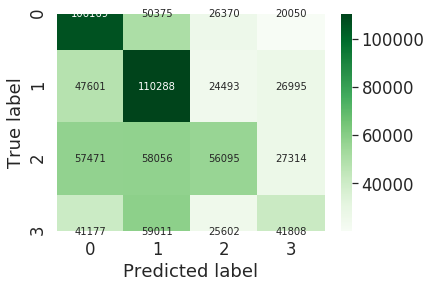

In [22]:
confusion_matrix_heatmap(y_true, y_pred)

In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.52      0.47    202964
           1       0.40      0.53      0.45    209377
           2       0.42      0.28      0.34    198936
           3       0.36      0.25      0.29    167598

    accuracy                           0.40    778875
   macro avg       0.40      0.40      0.39    778875
weighted avg       0.40      0.40      0.39    778875



# Build model: Emb+2GRU+DENSE

In [88]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE+1, 128, input_length=X.shape[1], mask_zero=True))
model.add(GRU(256, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(128, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 30, 200)           1000      
_________________________________________________________________
gru_26 (GRU)                 (None, 30, 128)           126336    
_________________________________________________________________
dropout_25 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
gru_27 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 325       
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
Total para

In [86]:
path = './same_/GRU.h5'

BATCH_SIZE=200
n_epochs=160

checkpoint = [EarlyStopping(patience=10, monitor='val_loss'),
             ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, 
          verbose=1, callbacks=checkpoint, shuffle=True, validation_split=0.2).history

In [ ]:
plot_metrics(history)

# OOB validation

In [9]:
model = load_model(path)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

y_test = np.argmax(y_test, axis=-1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


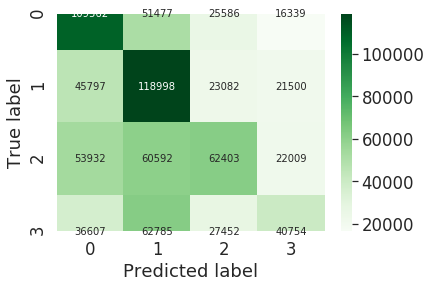

In [15]:
confusion_matrix_heatmap(y_test, y_pred)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.54      0.49    202964
           2       0.40      0.57      0.47    209377
           3       0.45      0.31      0.37    198936
           4       0.41      0.24      0.30    167598

    accuracy                           0.43    778875
   macro avg       0.43      0.42      0.41    778875
weighted avg       0.43      0.43      0.41    778875

